In [1]:
import time
import torch
from torch import nn, optim
import torchvision
import sys
import numpy as np
from torchvision import models
import torch.nn.init as init
from typing import Any
from collections import OrderedDict

# AlexNet

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(25)

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:
alexnet = AlexNet().to(device)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
alexnet.classifier[1] = nn.Linear(9216,4096)
alexnet.classifier[4] = nn.Linear(4096,1024)
alexnet.classifier[6] = nn.Linear(1024,2)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
import cv2
import os

def getStat(train_data):
    print('Compute mean and std for training data.')
    print(len(train_data))
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=1, shuffle=False, num_workers=0,
        pin_memory=True)
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for X, Y in train_loader:
        for d in range(3):
            mean[d] += X[:, d, :, :].mean()
            std[d] += X[:, d, :, :].std()
    mean.div_(len(train_data))
    std.div_(len(train_data))
    return list(mean.numpy()), list(std.numpy())

if __name__ == '__main__':
    train_dataset = ImageFolder(root=os.getcwd()+ "/downloads/COVID-19-3/Train/", transform=transforms.ToTensor())  #get_transform_for_train()
    print(getStat(train_dataset))

Compute mean and std for training data.
5000
([0.32524452, 0.32524452, 0.32524452], [0.3328115, 0.3328115, 0.3328115])


In [6]:
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.32524452, 0.32524452, 0.32524452], std=[0.3328115, 0.3328115, 0.3328115]),
])

In [7]:
from torchvision import datasets
import os, os.path

data_root = os.getcwd()
image_path = data_root + "/downloads/COVID-19-3/Train/"
train_dataset = datasets.ImageFolder(root = image_path, transform = preprocess)
lung_list = train_dataset.class_to_idx

train_num = len(train_dataset)
batch_size = 4
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True)

val_dataset = datasets.ImageFolder(root = data_root + "/downloads/COVID-19-3/Test/", transform = preprocess)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True)

classes = ("Normal", "Abnormal")

[1,   625] loss: 0.551
Time: 110.96156191825867
[1,  1250] loss: 0.416
Time: 220.21117496490479
Epoch 1 : Train accuracy: 86.02 % , Test accuracy: 80.60 %
[2,   625] loss: 0.331
Time: 111.2601363658905
[2,  1250] loss: 0.289
Time: 220.4559624195099
Epoch 2 : Train accuracy: 90.78 % , Test accuracy: 85.20 %
[3,   625] loss: 0.240
Time: 111.65208292007446
[3,  1250] loss: 0.198
Time: 221.31571865081787
Epoch 3 : Train accuracy: 94.24 % , Test accuracy: 88.60 %
[4,   625] loss: 0.172
Time: 111.2907567024231
[4,  1250] loss: 0.157
Time: 220.48897576332092
Epoch 4 : Train accuracy: 93.60 % , Test accuracy: 93.40 %
[5,   625] loss: 0.143
Time: 111.39577579498291
[5,  1250] loss: 0.129
Time: 220.57765316963196
Epoch 5 : Train accuracy: 95.06 % , Test accuracy: 89.60 %
[6,   625] loss: 0.102
Time: 111.22350358963013
[6,  1250] loss: 0.090
Time: 220.50161862373352
Epoch 6 : Train accuracy: 95.60 % , Test accuracy: 86.40 %
[7,   625] loss: 0.068
Time: 111.24895191192627
[7,  1250] loss: 0.066
Ti

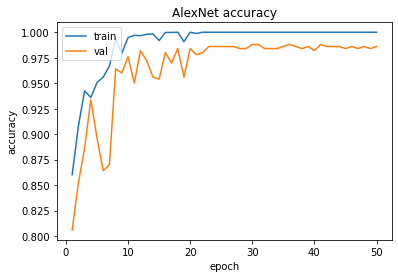

In [8]:
import time
from matplotlib import pyplot as plt

lr = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.parameters(), lr=lr, momentum=0.9)

acc_t = []
acc_v = []
epoch_counts = []

for epoch in range(50):  # loop over the dataset multiple times
    
    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(train_iter, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = alexnet(inputs)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 625 == 624:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 625))
            print('Time:',time_taken)
            running_loss = 0.0
    
    #Testing Accuracy
    correct_t = 0
    total_t = 0
    
    with torch.no_grad():
        for data in train_iter:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = alexnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total_t += labels.size(0)
            correct_t += (predicted == labels).sum().item()
    acc_t.append(correct_t / total_t)
            
    correct_v = 0
    total_v = 0
    
    with torch.no_grad():
        for data in val_iter:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = alexnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total_v += labels.size(0)
            correct_v += (predicted == labels).sum().item()
    acc_v.append(correct_v / total_v)
    
    epoch_counts.append(epoch + 1)
            
    print('Epoch', epoch + 1,': Train accuracy: %.2f %%' % (100 * correct_t / total_t), ', Test accuracy: %.2f %%' % (100 * correct_v / total_v))
    
print('Finished Training of AlexNet')

plt.plot(epoch_counts, acc_t)
plt.plot(epoch_counts, acc_v)
plt.title('AlexNet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
class_FP_TP = list(0. for i in range(10))
class_TN_FN = list(0. for i in range(10))
with torch.no_grad():
    for data in val_iter:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c0 = (predicted == 0).squeeze()
        c1 = (predicted == 1).squeeze()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_FP_TP[label] += c1[i].item()
            class_TN_FN[label] += c0[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

Precision0 = 100 * class_TN_FN[0] / (class_TN_FN[0] + class_TN_FN[1])
Recall0 = 100 * class_TN_FN[0]/ (class_TN_FN[0] + class_FP_TP[0])
F10 = 2 * (Precision0 * Recall0) / (Precision0 + Recall0)
print('Numbers of FP for', classes[0], ':', int(class_TN_FN[1]))
print('Numbers of FN for', classes[0], ':', int(class_FP_TP[0]))
print('Precision of %5s : %2d %%' % (classes[0], Precision0))
print('Recall of %5s : %2d %%' % (classes[0], Recall0))
print('Accuracy of %5s : %2d %%' % (classes[0], 100 * class_correct[0] / class_total[0]))
print('F1-score of %5s : %2d %%' % (classes[0], F10))
print()

Precision1 = 100 * class_FP_TP[1] / (class_FP_TP[1] + class_FP_TP[0])
Recall1 = 100 * class_FP_TP[1] / (class_FP_TP[1] + class_TN_FN[1])
F11 = 2 * (Precision1 * Recall1) / (Precision1 + Recall1)
print('Numbers of FP for', classes[1], ':', int(class_FP_TP[0]))
print('Numbers of FN for', classes[1], ':', int(class_TN_FN[1]))
print('Precision of %5s : %2d %%' % (classes[1], Precision1))
print('Recall of %5s : %2d %%' % (classes[1], Recall1))
print('Accuracy of %5s : %2d %%' % (classes[1], 100 * class_correct[1] / class_total[1]))
print('F1-score of %5s : %2d %%' % (classes[1], F11))

Numbers of FP for Normal : 6
Numbers of FN for Normal : 3
Precision of Normal : 97 %
Recall of Normal : 98 %
Accuracy of Normal : 98 %
F1-score of Normal : 98 %

Numbers of FP for Abnormal : 3
Numbers of FN for Abnormal : 6
Precision of Abnormal : 98 %
Recall of Abnormal : 97 %
Accuracy of Abnormal : 97 %
F1-score of Abnormal : 98 %


# SqueezeNet

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(25)

class Fire(nn.Module):

    def __init__(
        self,
        inplanes: int,
        squeeze_planes: int,
        expand1x1_planes: int,
        expand3x3_planes: int
    ) -> None:
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

class SqueezeNet(nn.Module):

    def __init__(
        self,
        version: str = '1_0',
        num_classes: int = 1000
    ) -> None:
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        if version == '1_0':
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        elif version == '1_1':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        else:
            # FIXME: Is this needed? SqueezeNet should only be called from the
            # FIXME: squeezenet1_x() functions
            # FIXME: This checking is not done for the other models
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1_0 or 1_1 expected".format(version=version))

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)
    
def _squeezenet(version: str, pretrained: bool, progress: bool, **kwargs: Any) -> SqueezeNet:
    model = SqueezeNet(version, **kwargs)
    if pretrained:
        arch = 'squeezenet' + version
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [11]:
squeezenet = SqueezeNet()
squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [12]:
squeezenet.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))
squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [13]:
from torchvision import datasets
import os, os.path

data_root = os.getcwd()
image_path = data_root + "/downloads/COVID-19-3/Train/"
train_dataset = datasets.ImageFolder(root = image_path, transform = preprocess)
lung_list = train_dataset.class_to_idx

train_num = len(train_dataset)
batch_size = 16
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True)

val_dataset = datasets.ImageFolder(root = data_root + "/downloads/COVID-19-3/Test/", transform = preprocess)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True)

classes = ("Normal", "Abnormal")

[1,   300] loss: 0.030
Time: 186.5429036617279
Epoch 1 : Train accuracy: 81.21 % , Test accuracy: 72.78 %
[2,   300] loss: 0.024
Time: 186.52884030342102
Epoch 2 : Train accuracy: 84.07 % , Test accuracy: 76.61 %
[3,   300] loss: 0.021
Time: 186.8143346309662
Epoch 3 : Train accuracy: 59.98 % , Test accuracy: 49.80 %
[4,   300] loss: 0.026
Time: 187.29887771606445
Epoch 4 : Train accuracy: 88.00 % , Test accuracy: 79.03 %
[5,   300] loss: 0.016
Time: 187.24760818481445
Epoch 5 : Train accuracy: 86.40 % , Test accuracy: 83.06 %
[6,   300] loss: 0.016
Time: 187.37172722816467
Epoch 6 : Train accuracy: 93.23 % , Test accuracy: 87.90 %
[7,   300] loss: 0.013
Time: 187.62095546722412
Epoch 7 : Train accuracy: 91.85 % , Test accuracy: 83.06 %
[8,   300] loss: 0.013
Time: 187.23666834831238
Epoch 8 : Train accuracy: 91.45 % , Test accuracy: 90.32 %
[9,   300] loss: 0.011
Time: 187.48887467384338
Epoch 9 : Train accuracy: 86.32 % , Test accuracy: 85.89 %
[10,   300] loss: 0.012
Time: 187.55624

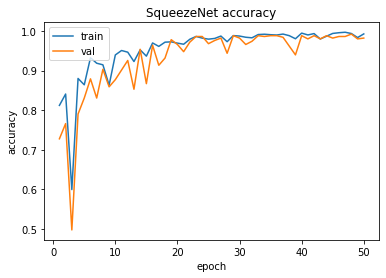

In [14]:
import time
from matplotlib import pyplot as plt

lr = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(squeezenet.parameters(), lr=lr, momentum=0.9)

acc_t = []
acc_v = []
epoch_counts = []

for epoch in range(50):  # loop over the dataset multiple times
    
    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(train_iter, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = squeezenet(inputs)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 5000))
            print('Time:',time_taken)
            running_loss = 0.0
    
    #Testing Accuracy
    correct_t = 0
    total_t = 0
    
    with torch.no_grad():
        for data in train_iter:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = squeezenet(images)
            _, predicted = torch.max(outputs.data, 1)
            total_t += labels.size(0)
            correct_t += (predicted == labels).sum().item()
    acc_t.append(correct_t / total_t)
            
    correct_v = 0
    total_v = 0
    
    with torch.no_grad():
        for data in val_iter:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = squeezenet(images)
            _, predicted = torch.max(outputs.data, 1)
            total_v += labels.size(0)
            correct_v += (predicted == labels).sum().item()
    acc_v.append(correct_v / total_v)
    
    epoch_counts.append(epoch + 1)
            
    print('Epoch', epoch + 1,': Train accuracy: %.2f %%' % (100 * correct_t / total_t), ', Test accuracy: %.2f %%' % (100 * correct_v / total_v))
    
print('Finished Training of SqueezeNet')

plt.plot(epoch_counts, acc_t)
plt.plot(epoch_counts, acc_v)
plt.title('SqueezeNet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
class_FP_TP = list(0. for i in range(10))
class_TN_FN = list(0. for i in range(10))
with torch.no_grad():
    for data in val_iter:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = squeezenet(images)
        _, predicted = torch.max(outputs, 1)
        c0 = (predicted == 0).squeeze()
        c1 = (predicted == 1).squeeze()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_FP_TP[label] += c1[i].item()
            class_TN_FN[label] += c0[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

Precision0 = 100 * class_TN_FN[0] / (class_TN_FN[0] + class_TN_FN[1])
Recall0 = 100 * class_TN_FN[0]/ (class_TN_FN[0] + class_FP_TP[0])
F10 = 2 * (Precision0 * Recall0) / (Precision0 + Recall0)
print('Numbers of FP for', classes[0], ':', int(class_TN_FN[1]))
print('Numbers of FN for', classes[0], ':', int(class_FP_TP[0]))
print('Precision of %5s : %2d %%' % (classes[0], Precision0))
print('Recall of %5s : %2d %%' % (classes[0], Recall0))
print('Accuracy of %5s : %2d %%' % (classes[0], 100 * class_correct[0] / class_total[0]))
print('F1-score of %5s : %2d %%' % (classes[0], F10))
print()

Precision1 = 100 * class_FP_TP[1] / (class_FP_TP[1] + class_FP_TP[0])
Recall1 = 100 * class_FP_TP[1] / (class_FP_TP[1] + class_TN_FN[1])
F11 = 2 * (Precision1 * Recall1) / (Precision1 + Recall1)
print('Numbers of FP for', classes[1], ':', int(class_FP_TP[0]))
print('Numbers of FN for', classes[1], ':', int(class_TN_FN[1]))
print('Precision of %5s : %2d %%' % (classes[1], Precision1))
print('Recall of %5s : %2d %%' % (classes[1], Recall1))
print('Accuracy of %5s : %2d %%' % (classes[1], 100 * class_correct[1] / class_total[1]))
print('F1-score of %5s : %2d %%' % (classes[1], F11))

Numbers of FP for Normal : 2
Numbers of FN for Normal : 0
Precision of Normal : 96 %
Recall of Normal : 100 %
Accuracy of Normal : 100 %
F1-score of Normal : 98 %

Numbers of FP for Abnormal : 0
Numbers of FN for Abnormal : 2
Precision of Abnormal : 100 %
Recall of Abnormal : 97 %
Accuracy of Abnormal : 97 %
F1-score of Abnormal : 98 %


# LeNet-5

In [16]:
class C1(nn.Module):
    def __init__(self):
        super(C1, self).__init__()

        self.c1 = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s1', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))

    def forward(self, img):
        output = self.c1(img)
        return output


class C2(nn.Module):
    def __init__(self):
        super(C2, self).__init__()

        self.c2 = nn.Sequential(OrderedDict([
            ('c2', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu2', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))

    def forward(self, img):
        output = self.c2(img)
        return output


class C3(nn.Module):
    def __init__(self):
        super(C3, self).__init__()

        self.c3 = nn.Sequential(OrderedDict([
            ('c3', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu3', nn.ReLU())
        ]))

    def forward(self, img):
        output = self.c3(img)
        return output


class F4(nn.Module):
    def __init__(self):
        super(F4, self).__init__()

        self.f4 = nn.Sequential(OrderedDict([
            ('f4', nn.Linear(120, 84)),
            ('relu4', nn.ReLU())
        ]))

    def forward(self, img):
        output = self.f4(img)
        return output


class F5(nn.Module):
    def __init__(self):
        super(F5, self).__init__()

        self.f5 = nn.Sequential(OrderedDict([
            ('f5', nn.Linear(84, 2)),
            ('sig5', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.f5(img)
        return output


class LeNet5(nn.Module):
    """
    Input - 1x32x32
    Output - 10
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.c1 = C1()
        self.c2_1 = C2() 
        self.c2_2 = C2() 
        self.c3 = C3() 
        self.f4 = F4() 
        self.f5 = F5() 

    def forward(self, img):
        output = self.c1(img)

        x = self.c2_1(output)
        output = self.c2_2(output)

        output += x

        output = self.c3(output)
        output = output.view(img.size(0), -1)
        output = self.f4(output)
        output = self.f5(output)
        return output

In [17]:
lenet = LeNet5()
lenet

LeNet5(
  (c1): C1(
    (c1): Sequential(
      (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (relu1): ReLU()
      (s1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (c2_1): C2(
    (c2): Sequential(
      (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (relu2): ReLU()
      (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (c2_2): C2(
    (c2): Sequential(
      (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (relu2): ReLU()
      (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (c3): C3(
    (c3): Sequential(
      (c3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
      (relu3): ReLU()
    )
  )
  (f4): F4(
    (f4): Sequential(
      (f4): Linear(in_features=120, out_features=84, bias=True)
      (relu4): ReLU()
    )
  )
  (f5): F5(
    (f5): Sequential(
      (f5): Linear(in_features=84, out_

In [18]:
import time
from matplotlib import pyplot as plt

lr = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet.parameters(), lr=lr, momentum=0.9)

acc_t = []
acc_v = []
epoch_counts = []

for epoch in range(10):  # loop over the dataset multiple times
    
    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(train_iter, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = lenet(inputs)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 1250 == 1249:    # print every 1250 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0
    
    #Testing Accuracy
    correct_t = 0
    total_t = 0
    
    with torch.no_grad():
        for data in train_iter:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = lenet(images)
            _, predicted = torch.max(outputs.data, 1)
            total_t += labels.size(0)
            correct_t += (predicted == labels).sum().item()
    acc_t.append(correct_t / total_t)
            
    correct_v = 0
    total_v = 0
    
    with torch.no_grad():
        for data in val_iter:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = lenet(images)
            _, predicted = torch.max(outputs.data, 1)
            total_v += labels.size(0)
            correct_v += (predicted == labels).sum().item()
    acc_v.append(correct_v / total_v)
    
    epoch_counts.append(epoch + 1)
            
    print('Epoch', epoch + 1,': Train accuracy: %.2f %%' % (100 * correct_t / total_t), ', Test accuracy: %.2f %%' % (100 * correct_v / total_v))
    
print('Finished Training of LeNet-5')

plt.plot(epoch_counts, acc_t)
plt.plot(epoch_counts, acc_v)
plt.title('LeNet-5 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

RuntimeError: Given groups=1, weight of size [6, 1, 5, 5], expected input[16, 3, 224, 224] to have 1 channels, but got 3 channels instead

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in val_iter:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = lenet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))